In [1]:
%store -z

In [2]:
import pandas as pd
import numpy as np
import missingno as msno 
import seaborn as sns
import matplotlib.pyplot as plt 

#import warnings
#warnings.filterwarnings('ignore')



In [3]:
# client data
df_clients =pd.read_csv('data/client_train.csv')

# invoice score
df_invoice =pd.read_csv('data/invoice_train.csv')

/var/folders/xc/hzxkdm6x30g7x6m188q7h66h0000gn/T/ipykernel_4348/3352888719.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_invoice =pd.read_csv('data/invoice_train.csv')


In [4]:
df_clients.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [5]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [6]:
df_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [7]:
df_invoice[['client_id', 'invoice_date', 'old_index', 'new_index']].query('client_id == "train_Client_0"').sort_values(by=['invoice_date'])

,client_id,invoice_date,old_index,new_index
22,train_Client_0,2005-10-17,3685,3809
23,train_Client_0,2006-02-24,3809,3950
24,train_Client_0,2006-06-23,3950,4112
25,train_Client_0,2006-10-18,4112,4271
28,train_Client_0,2007-02-26,4271,4453
26,train_Client_0,2007-06-27,4453,4693
27,train_Client_0,2007-10-25,4693,4969
34,train_Client_0,2008-01-04,4969,5246
29,train_Client_0,2008-07-28,5246,5417
10,train_Client_0,2008-11-25,5417,5591


## Column descriptions:

### Client Data

* Client_id: Unique id for client
* District: District where the client is
* Client_catg: Category client belongs to
* Region: Area where the client is
* Creation_date: Date client joined
* Target: fraud:1 , not fraud: 0

### Invoice Data

* Client_id: Unique id for the client
* Invoice_date: Date of the invoice
* Tarif_type: Type of tax
* Counter_number:
* Counter_statue: takes up to 5 values such as working fine, not working, on hold statue, ect
* Counter_code:
* Reading_remarque: notes that the STEG agent takes during his visit to the client (e.g: If the counter shows something wrong, the agent gives a bad score)
* Counter_coefficient: An additional coefficient to be added when standard consumption is exceeded
* Consommation_level_1: Consumption_level_1
* Consommation_level_2: Consumption_level_2
* Consommation_level_3: Consumption_level_3
* Consommation_level_4: Consumption_level_4
* Old_index: Old index
* New_index: New index
* Months_number: Month number
* Counter_type: Type of counter

 the consumption level refers to the threshold of consumption to which a certain price is attributed

In [8]:
#Y = coffee_quality["quality_score"]

# Data cleaningin and feature engineering

In [9]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


In [10]:
df_invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [11]:
df_invoice.isnull().sum()

client_id               0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [12]:
df_invoice.describe().T

,count,mean,std,min,25%,50%,75%,max
tarif_type,4476749.0,2.012804e+01,1.347256e+01,8.0,11.0,11.0,40.0,4.500000e+01
counter_number,4476749.0,1.230587e+11,1.657267e+12,0.0,121108.0,494561.0,1115161.0,2.798115e+13
counter_code,4476749.0,1.724884e+02,1.338871e+02,0.0,5.0,203.0,207.0,6.000000e+02
reading_remarque,4476749.0,7.321702e+00,1.571654e+00,5.0,6.0,8.0,9.0,4.130000e+02
counter_coefficient,4476749.0,1.003040e+00,3.083466e-01,0.0,1.0,1.0,1.0,5.000000e+01
consommation_level_1,4476749.0,4.109795e+02,7.573080e+02,0.0,79.0,274.0,600.0,9.999100e+05
consommation_level_2,4476749.0,1.093225e+02,1.220123e+03,0.0,0.0,0.0,0.0,9.990730e+05
consommation_level_3,4476749.0,2.030620e+01,1.574239e+02,0.0,0.0,0.0,0.0,6.449200e+04
consommation_level_4,4476749.0,5.292588e+01,8.754725e+02,0.0,0.0,0.0,0.0,5.479460e+05
old_index,4476749.0,1.776700e+04,4.036693e+04,0.0,1791.0,7690.0,21660.0,2.800280e+06


In [13]:
df_joined =  pd.merge(df_clients, df_invoice, on="client_id", how="left")
#df_clients.join(df_invoice, on='client_id', how='left')

In [14]:
df_joined.head(10)

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,31/12/1994,0.0,2014-03-24,11,1335667,0,...,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,31/12/1994,0.0,2013-03-29,11,1335667,0,...,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,31/12/1994,0.0,2015-03-23,11,1335667,0,...,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,31/12/1994,0.0,2015-07-13,11,1335667,0,...,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,31/12/1994,0.0,2016-11-17,11,1335667,0,...,9,1,572,0,0,0,15066,15638,12,ELEC
5,60,train_Client_0,11,101,31/12/1994,0.0,2017-07-17,11,1335667,0,...,9,1,314,0,0,0,15638,15952,8,ELEC
6,60,train_Client_0,11,101,31/12/1994,0.0,2018-12-07,11,1335667,0,...,9,1,541,0,0,0,15952,16493,12,ELEC
7,60,train_Client_0,11,101,31/12/1994,0.0,2019-03-19,11,1335667,0,...,9,1,585,0,0,0,16493,17078,8,ELEC
8,60,train_Client_0,11,101,31/12/1994,0.0,2011-07-22,11,1335667,0,...,9,1,1200,186,0,0,7770,9156,4,ELEC
9,60,train_Client_0,11,101,31/12/1994,0.0,2011-11-22,11,1335667,0,...,6,1,1082,0,0,0,9156,10238,4,ELEC


In [15]:
print(df_joined.client_id.nunique())
df_joined.counter_number.nunique()

135493


201893

In [16]:
df_joined.nunique()

disrict                      4
client_id               135493
client_catg                  3
region                      25
creation_date             8088
target                       2
invoice_date              8275
tarif_type                  17
counter_number          201893
counter_statue              16
counter_code                42
reading_remarque             8
counter_coefficient         16
consommation_level_1      8295
consommation_level_2     12576
consommation_level_3      2253
consommation_level_4     12075
old_index               155648
new_index               157980
months_number             1370
counter_type                 2
dtype: int64

In [17]:
df_joined.counter_type.unique()

array(['ELEC', 'GAZ'], dtype=object)

In [18]:
df_joined.client_catg.unique()

array([11, 12, 51])

In [19]:
df_joined.tarif_type.unique()

array([11, 40, 15, 10, 12, 14, 13, 45, 29,  9, 30,  8, 21, 42, 27, 18, 24])

In [20]:
df_joined.groupby('counter_statue').count()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
counter_statue,,,,,,,,,,,,,,,,,,,,
0,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960,4346960
1,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496,73496
2,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32
3,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258,258
4,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706,2706
5,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495,20495
46,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14
420,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
618,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12


In [21]:
df_joined.groupby('counter_code').count()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
counter_code,,,,,,,,,,,,,,,,,,,,
0,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33,33
1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035,1352035
10,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744,27744
16,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73,73
25,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934,14934
40,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482,2482
65,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74
101,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74,74


In [22]:
df_joined.counter_code.unique()

array([203, 207, 413,   5, 467, 202, 420, 410,  10, 483,  25, 433, 407,
       204, 214, 442, 453, 506, 450, 403, 333, 201, 102, 305, 210, 101,
       532,  40, 310, 565, 600, 307, 303, 222,  65,   0, 227, 325,  16,
       317, 367,   1])

In [23]:
df_joined.reading_remarque.unique()

array([  8,   6,   9,   7, 207, 413, 203,   5])

In [24]:
df_joined.groupby('reading_remarque').count()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,counter_code,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
reading_remarque,,,,,,,,,,,,,,,,,,,,
5,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
6,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939,2230939
7,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661,661
8,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123,828123
9,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992,1416992
203,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
207,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
413,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12,12


In [25]:
df_joined.counter_coefficient.unique()

array([ 1,  3,  0, 10,  4, 33, 50, 20,  2,  6, 40,  9, 30,  5, 11,  8])

In [26]:
df_joined.old_index.unique()

array([ 14302,  12294,  14624, ..., 141551, 110850,  86004])

In [27]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   disrict               int64  
 1   client_id             object 
 2   client_catg           int64  
 3   region                int64  
 4   creation_date         object 
 5   target                float64
 6   invoice_date          object 
 7   tarif_type            int64  
 8   counter_number        int64  
 9   counter_statue        object 
 10  counter_code          int64  
 11  reading_remarque      int64  
 12  counter_coefficient   int64  
 13  consommation_level_1  int64  
 14  consommation_level_2  int64  
 15  consommation_level_3  int64  
 16  consommation_level_4  int64  
 17  old_index             int64  
 18  new_index             int64  
 19  months_number         int64  
 20  counter_type          object 
dtypes: float64(1), int64(15), object(5)
memory usage: 717.3+ MB


## To Dos

* remove client_id column
* turn into dummies: client_catg, tarif_type
* change target to 0,1 - DONE
* turn creation_date, invoice_date  into datetime or something else - DONE
* feature engineering: number of counters per client. then drop client_id, counter_number
* counter_statue: turn strings 0-5 into int, check percentage of values not 0-5, check for pattern, remove - DONE
* counter_code: either dummies or find info on steg site or drop?
* reading_remarque: clean? turn into dummies
* counter_coefficient: try both?: treat numerically and as dummies?
* rescale consommation_level1 ... _4
* drop index old and new
* rescale months_number
* turn into dummy counter_type

In [28]:
# check how many duplicated rows exist in the data frame
df_joined.duplicated().value_counts()

# there were 11 duplicatge rows, drop duplicates
df_joined.drop_duplicates(inplace=True)

In [29]:
df_joined['counter_statue'].unique()

array([0, 1, 5, 4, 3, 2, 769, '0', '5', '1', '4', 'A', 618, 269375, 46,
       420], dtype=object)

In [30]:
# counter_statue: turn strings 0-5 into int, check percentage of values not 0-5, check for pattern, remove

df_joined['counter_statue'] = df_joined['counter_statue'].map({
    '0': 0,
    0: 0, 
    1: 1,
    2 : 2,
    3: 3,
    4: 4,  
    5: 5,
    '5': 5,
    '1': 1,
    '4': 4, 
    'A': np.nan,
    618: np.nan, 
    269375: np.nan,
    46: np.nan, 
    420: np.nan,
    769: np.nan, 
    })
df_joined['counter_statue'].nunique()

6

In [31]:
df_joined['counter_statue'].unique()

array([ 0.,  1.,  5.,  4.,  3.,  2., nan])

In [32]:
# check for missing distribution

#msno.matrix(df_joined)

In [33]:
# calculate fraction of data we would lose : 0.001%

print(f"numbers of rows : {df_joined.shape[0]}")
print(f"missing values in counter statue : {round(df_joined.counter_statue.isna().sum()/df_joined.shape[0]*100,4)} %")

# copy df
df_processed = df_joined.copy()
# drop NaN
df_processed.dropna(inplace=True, axis=0)


numbers of rows : 4476738
missing values in counter statue : 0.001 %


In [34]:
df_joined.isna().sum()

disrict                  0
client_id                0
client_catg              0
region                   0
creation_date            0
target                   0
invoice_date             0
tarif_type               0
counter_number           0
counter_statue          47
counter_code             0
reading_remarque         0
counter_coefficient      0
consommation_level_1     0
consommation_level_2     0
consommation_level_3     0
consommation_level_4     0
old_index                0
new_index                0
months_number            0
counter_type             0
dtype: int64

In [35]:
df_processed.isna().sum()

disrict                 0
client_id               0
client_catg             0
region                  0
creation_date           0
target                  0
invoice_date            0
tarif_type              0
counter_number          0
counter_statue          0
counter_code            0
reading_remarque        0
counter_coefficient     0
consommation_level_1    0
consommation_level_2    0
consommation_level_3    0
consommation_level_4    0
old_index               0
new_index               0
months_number           0
counter_type            0
dtype: int64

In [36]:
df_processed['target'].unique()

array([0., 1.])

In [37]:
# change target from float to int (0,1)
df_processed.target = df_processed.target.astype(int)
df_processed.target.unique()

array([0, 1])

In [38]:
df_processed.head()

,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,60,train_Client_0,11,101,31/12/1994,0,2014-03-24,11,1335667,0.0,...,8,1,82,0,0,0,14302,14384,4,ELEC
1,60,train_Client_0,11,101,31/12/1994,0,2013-03-29,11,1335667,0.0,...,6,1,1200,184,0,0,12294,13678,4,ELEC
2,60,train_Client_0,11,101,31/12/1994,0,2015-03-23,11,1335667,0.0,...,8,1,123,0,0,0,14624,14747,4,ELEC
3,60,train_Client_0,11,101,31/12/1994,0,2015-07-13,11,1335667,0.0,...,8,1,102,0,0,0,14747,14849,4,ELEC
4,60,train_Client_0,11,101,31/12/1994,0,2016-11-17,11,1335667,0.0,...,9,1,572,0,0,0,15066,15638,12,ELEC


In [39]:
# turn columns invoice date and creation date to datetime

df_processed['invoice_date'] = pd.to_datetime(df_processed['invoice_date'], format='%Y-%m-%d')
df_processed['creation_date'] = pd.to_datetime(df_processed['creation_date'], format='%d/%m/%Y')

## Establishing Baseline Model

In [40]:
df_processed.columns

Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type'],
      dtype='object')

<Axes: >

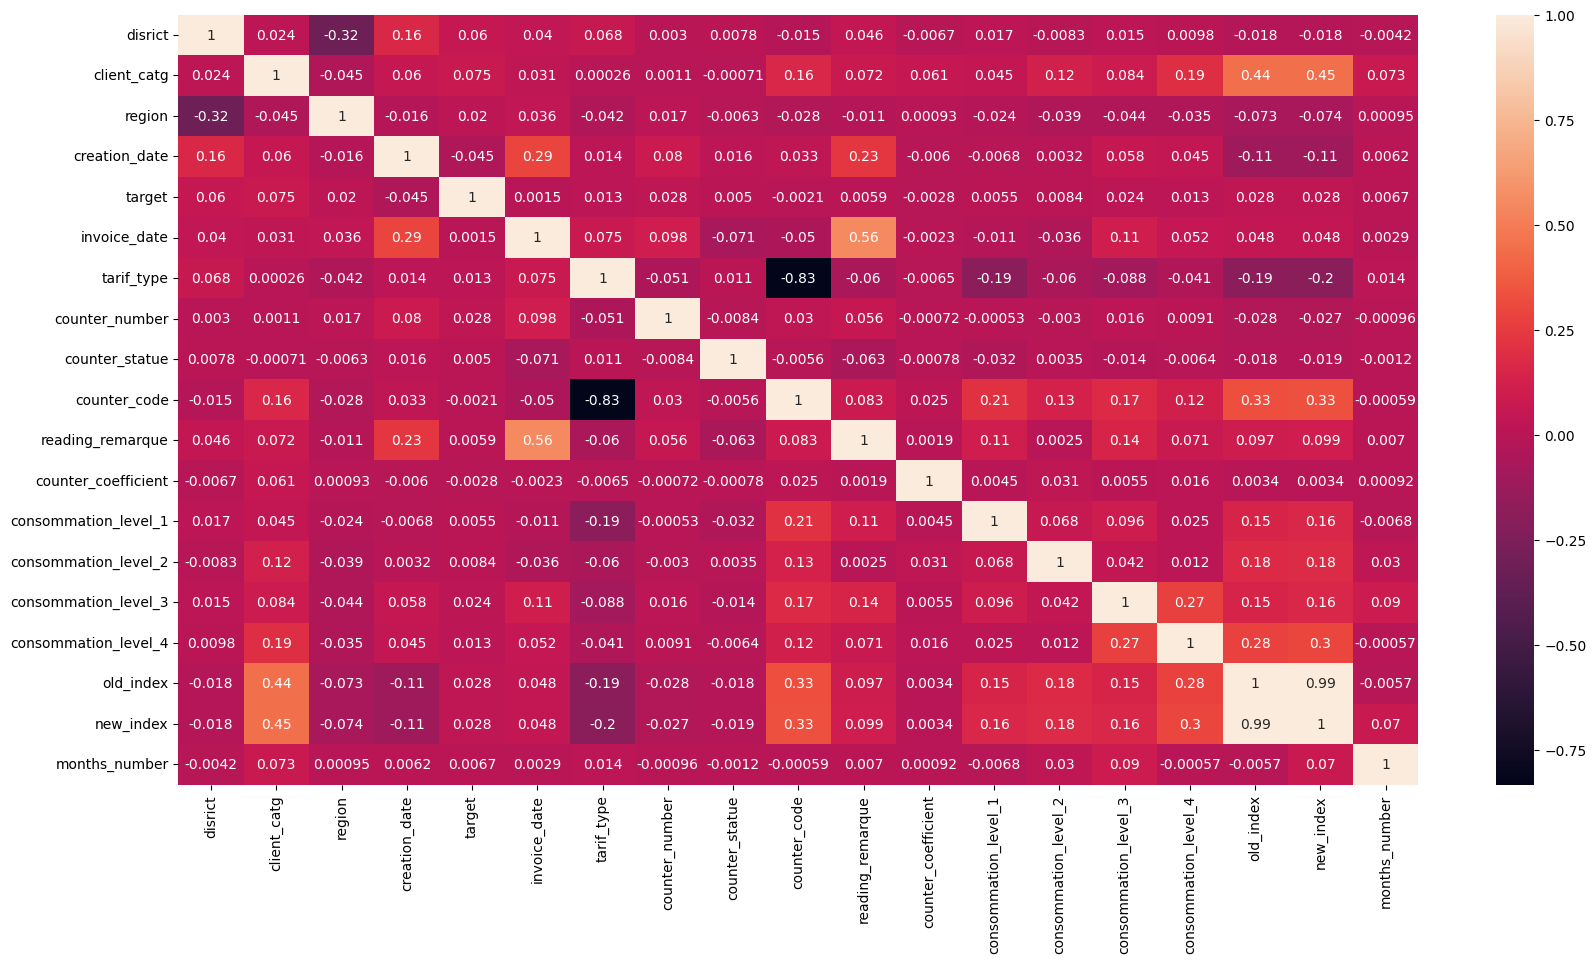

In [41]:
# heatmap
fig = plt.figure(figsize=(20,10))
sns.heatmap(df_processed[['disrict', 'client_catg', 'region', 'creation_date',
       'target', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number']].corr(), annot=True)



In [42]:
# the pairplot took a lot of time so we did not see it so far and left it for now

# pairplot

# fig = plt.figure(figsize=(20,10))
# sns.pairplot(df_processed[['disrict', 'client_catg', 'region', 'creation_date', 'invoice_date', 'tarif_type', 'counter_number',
#        'counter_statue', 'counter_code', 'reading_remarque',
#        'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
#        'consommation_level_3', 'consommation_level_4', 'months_number', 'target']], hue='target')

In [43]:

# fig = plt.figure(figsize=(20,10))
# sns.histplot(data= df_processed, x = 'reading_remarque', hue='target', stat='percent');

In [44]:
# # since our target has the highest correlation with the client category, we will take a closer look at that: 
# df_processed.client_catg.value_counts()

In [45]:
# # plot distribution of target for each client category 

# fig = plt.figure(figsize=(20,10))
# sns.countplot(data= df_processed, x = 'client_catg', hue='target');

In [46]:
# # plot distribution of target for each client category individually, descending by clients in category:

# fig = plt.figure(figsize=(20,10))
# sns.histplot(data= df_processed.query('client_catg == 11'), x = 'client_catg', hue='target', stat='percent');

In [47]:
# fig = plt.figure(figsize=(20,10))
# sns.histplot(data= df_processed.query('client_catg == 51'), x = 'client_catg', hue='target', stat='percent')

In [48]:
# fig = plt.figure(figsize=(20,10))
# sns.histplot(data= df_processed.query('client_catg == 12'), x = 'client_catg', hue='target', stat='percent')

In [49]:
# the highest amount of fraud happens by clients assigned to category 51, 
# so our very fist guess for a hypothesis and baseline mode could be:
# client category is the best predictor for fraud
# however, due tue the unbalanced data, this would be a very poor model.

## Next Steps
* run baseline model and print the different scores for it
* Drop old and new index
* Train-Test-Split
* Define Target y, and Features X
* Feature Engineering
* Dummy Creating
* Rescaling based on train, apply to test
* dropping other unused columns
* export X-test, X_train, y_test and y_train to a new notebook for modeling (find library to help us with that)
* individual modeling

## Feature Engineering

In [50]:
# # month and year from date columns
# df_processed['creation_month'] = df_processed['creation_date'].dt.month.astype(int)
# df_processed['creation_year'] = df_processed['creation_date'].dt.year.astype(int)
# df_processed['invoice_month'] = df_processed['invoice_date'].dt.month.astype(int)
# df_processed['invoice_year'] = df_processed['invoice_date'].dt.year.astype(int)

In [51]:
# number of years as client

df_processed['member_years'] = df_processed['invoice_date'].dt.year.astype(int) - df_processed['creation_date'].dt.year.astype(int)
df_processed.head()



,disrict,client_id,client_catg,region,creation_date,target,invoice_date,tarif_type,counter_number,counter_statue,...,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,member_years
0,60,train_Client_0,11,101,1994-12-31,0,2014-03-24,11,1335667,0.0,...,1,82,0,0,0,14302,14384,4,ELEC,20
1,60,train_Client_0,11,101,1994-12-31,0,2013-03-29,11,1335667,0.0,...,1,1200,184,0,0,12294,13678,4,ELEC,19
2,60,train_Client_0,11,101,1994-12-31,0,2015-03-23,11,1335667,0.0,...,1,123,0,0,0,14624,14747,4,ELEC,21
3,60,train_Client_0,11,101,1994-12-31,0,2015-07-13,11,1335667,0.0,...,1,102,0,0,0,14747,14849,4,ELEC,21
4,60,train_Client_0,11,101,1994-12-31,0,2016-11-17,11,1335667,0.0,...,1,572,0,0,0,15066,15638,12,ELEC,22


In [52]:
# drop creation_date and invoice_date
df_processed.drop(['creation_date','invoice_date'] , inplace=True,axis=1)
df_processed.head()

,disrict,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,member_years
0,60,train_Client_0,11,101,0,11,1335667,0.0,203,8,1,82,0,0,0,14302,14384,4,ELEC,20
1,60,train_Client_0,11,101,0,11,1335667,0.0,203,6,1,1200,184,0,0,12294,13678,4,ELEC,19
2,60,train_Client_0,11,101,0,11,1335667,0.0,203,8,1,123,0,0,0,14624,14747,4,ELEC,21
3,60,train_Client_0,11,101,0,11,1335667,0.0,207,8,1,102,0,0,0,14747,14849,4,ELEC,21
4,60,train_Client_0,11,101,0,11,1335667,0.0,207,9,1,572,0,0,0,15066,15638,12,ELEC,22


In [53]:
# tarif type valuecount

df_processed['tarif_type'].value_counts()



tarif_type
11    2679831
40    1379751
10     276210
15      72409
45      17552
13      11656
14      11611
12      11345
29      10090
9        6039
21        104
8          43
30         35
24          9
18          4
42          1
27          1
Name: count, dtype: int64

In [54]:
# bin tariff


df_processed['tarif_type'] = df_processed['tarif_type'].map({
    
    11 : 11,
    40 : 40,
    10 : 10,
    15  : 15,
    45   : 45,
    13  : 13,
    14  : 14,
    12  : 12,
    29  : 29,
    9  : 0,
    21  :0,
    8   : 0,
    30  : 0,
    24  : 0,
    18   : 0,
    42  : 0,
    27  :0
    
    })





In [55]:
# new feature index_change
df_processed['index_change']= df_processed['new_index'] - df_processed['old_index']

In [56]:
df_processed.query('months_number == 0').T

,3985967
disrict,69
client_id,train_Client_86638
client_catg,11
region,104
target,0
tarif_type,40
counter_number,128190
counter_statue,0.0
counter_code,5
reading_remarque,6


In [57]:
df_processed.query('client_id == "train_Client_86638"')

,disrict,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,...,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,member_years,index_change
3985915,69,train_Client_86638,11,104,0,40,128190,0.0,5,8,...,221,0,0,0,2799,3020,4,GAZ,7,221
3985916,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,546,0,0,0,49263,49809,4,ELEC,7,546
3985917,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,440,0,0,0,50363,50803,4,ELEC,8,440
3985918,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,554,0,0,0,49809,50363,4,ELEC,7,554
3985919,69,train_Client_86638,11,104,0,40,128190,0.0,5,8,...,167,0,0,0,3020,3187,4,GAZ,7,167
3985920,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,522,0,0,0,48741,49263,4,ELEC,7,522
3985921,69,train_Client_86638,11,104,0,11,95113,0.0,203,9,...,563,0,0,0,51349,51912,4,ELEC,8,563
3985922,69,train_Client_86638,11,104,0,40,128190,0.0,5,8,...,189,0,0,0,3320,3509,4,GAZ,8,189
3985923,69,train_Client_86638,11,104,0,40,128190,0.0,5,8,...,70,0,0,0,2226,2296,4,GAZ,6,70
3985924,69,train_Client_86638,11,104,0,40,128190,0.0,5,9,...,104,0,0,0,3611,3715,4,GAZ,8,104


In [58]:
# delete client with 0 consommation, 0 months_number...
df_processed.drop(index=3985967 , inplace=True,axis=0)

In [59]:
df_processed.query('months_number == 0')

,disrict,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,...,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,member_years,index_change


In [60]:
# index change per month


df_processed['index_change_month']= df_processed['index_change'] / df_processed['months_number']




In [61]:
# drop all  columns 
# Consummation_level_1 through 4, district, invoice_date, creation_date, counter_coefficient, index_change, months_number

df_processed.drop(['consommation_level_1', 'consommation_level_2', 'consommation_level_3', 'consommation_level_4',
                'disrict',  'counter_coefficient', 'index_change', 'months_number', 'counter_code'], inplace=True, axis=1)

In [62]:
df_processed.head()

,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,reading_remarque,old_index,new_index,counter_type,member_years,index_change_month
0,train_Client_0,11,101,0,11,1335667,0.0,8,14302,14384,ELEC,20,20.500000
1,train_Client_0,11,101,0,11,1335667,0.0,6,12294,13678,ELEC,19,346.000000
2,train_Client_0,11,101,0,11,1335667,0.0,8,14624,14747,ELEC,21,30.750000
3,train_Client_0,11,101,0,11,1335667,0.0,8,14747,14849,ELEC,21,25.500000
4,train_Client_0,11,101,0,11,1335667,0.0,9,15066,15638,ELEC,22,47.666667


In [63]:
#fig = plt.figure(figsize=(20,10))
#sns.histplot(data=df_processed, x='index_change' ,hue='target')

In [64]:
df_processed['index_change_month'].corr(df_processed['target']) #  correlation is very low 

0.007593112944907163

In [65]:
df_processed[['index_change_month']].describe()

,index_change_month
count,4.476690e+06
mean,1.578451e+02
std,2.234464e+03
min,-9.985390e+05
25%,1.975000e+01
50%,7.650000e+01
75%,1.575000e+02
max,2.744730e+05


In [66]:
df_processed.drop(['old_index','new_index'] , inplace=True,axis=1)


In [67]:
df_processed

,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,reading_remarque,counter_type,member_years,index_change_month
0,train_Client_0,11,101,0,11,1335667,0.0,8,ELEC,20,20.500000
1,train_Client_0,11,101,0,11,1335667,0.0,6,ELEC,19,346.000000
2,train_Client_0,11,101,0,11,1335667,0.0,8,ELEC,21,30.750000
3,train_Client_0,11,101,0,11,1335667,0.0,8,ELEC,21,25.500000
4,train_Client_0,11,101,0,11,1335667,0.0,9,ELEC,22,47.666667
...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,11,101,0,10,1253571,0.0,9,ELEC,12,66.875000
4476745,train_Client_99998,11,101,0,10,1253571,0.0,6,ELEC,12,51.500000
4476746,train_Client_99999,11,101,0,11,560948,0.0,6,ELEC,10,64.750000
4476747,train_Client_99999,11,101,0,11,560948,0.0,6,ELEC,10,150.750000


In [68]:
# counter per client feature
quantity_counter = df_processed.groupby('client_id')['counter_number'].count().reset_index()
quantity_counter.rename(columns={'counter_number':'quantity_counters'}, inplace=True)
quantity_counter.head()

,client_id,quantity_counters
0,train_Client_0,35
1,train_Client_1,37
2,train_Client_10,18
3,train_Client_100,20
4,train_Client_1000,14


In [69]:
df_processed = pd.merge(df_processed, quantity_counter, on="client_id", how="left")
df_processed.head()

,client_id,client_catg,region,target,tarif_type,counter_number,counter_statue,reading_remarque,counter_type,member_years,index_change_month,quantity_counters
0,train_Client_0,11,101,0,11,1335667,0.0,8,ELEC,20,20.500000,35
1,train_Client_0,11,101,0,11,1335667,0.0,6,ELEC,19,346.000000,35
2,train_Client_0,11,101,0,11,1335667,0.0,8,ELEC,21,30.750000,35
3,train_Client_0,11,101,0,11,1335667,0.0,8,ELEC,21,25.500000,35
4,train_Client_0,11,101,0,11,1335667,0.0,9,ELEC,22,47.666667,35


In [70]:
df_processed['quantity_counters'].corr(df_processed['target']) #  correlation is very low 

0.09323164725717187

In [71]:
# fig = plt.figure(figsize=(20,10))
# sns.histplot(df_processed, x='quantity_counters', hue='target')

In [72]:
# drop client_id and counter_number
df_processed.drop(['client_id','counter_number'] , inplace=True,axis=1)
df_processed.head()

,client_catg,region,target,tarif_type,counter_statue,reading_remarque,counter_type,member_years,index_change_month,quantity_counters
0,11,101,0,11,0.0,8,ELEC,20,20.500000,35
1,11,101,0,11,0.0,6,ELEC,19,346.000000,35
2,11,101,0,11,0.0,8,ELEC,21,30.750000,35
3,11,101,0,11,0.0,8,ELEC,21,25.500000,35
4,11,101,0,11,0.0,9,ELEC,22,47.666667,35


In [73]:
# rename district column
df_processed.rename(columns={'disrict':'district'}, inplace=True)

## Heatmap with the new features

In [74]:
df_processed.columns

Index(['client_catg', 'region', 'target', 'tarif_type', 'counter_statue',
       'reading_remarque', 'counter_type', 'member_years',
       'index_change_month', 'quantity_counters'],
      dtype='object')

<Axes: >

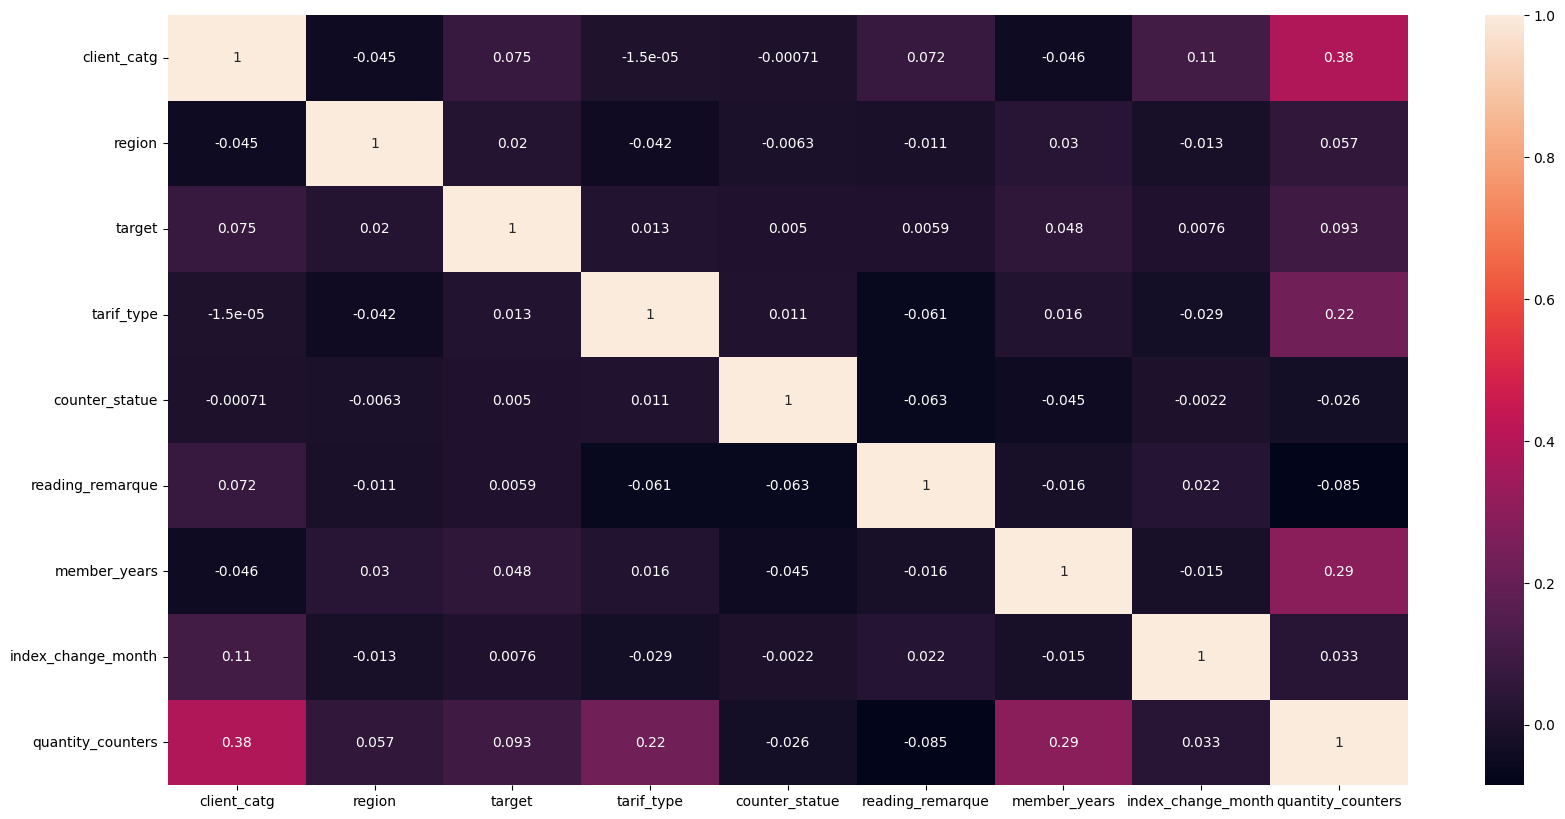

In [75]:
# heatmap
fig = plt.figure(figsize=(20,10))
sns.heatmap(df_processed[['client_catg', 'region', 'target', 'tarif_type', 'counter_statue',
       'reading_remarque',  'member_years',
       'index_change_month', 'quantity_counters']].corr(), annot=True)


## Turning Categorical Features into Dummies

In [76]:
df_processed.columns.to_list()

['client_catg',
 'region',
 'target',
 'tarif_type',
 'counter_statue',
 'reading_remarque',
 'counter_type',
 'member_years',
 'index_change_month',
 'quantity_counters']

In [77]:
cat_features = ['client_catg',
 'region',
 'tarif_type',
 'counter_statue',
 'reading_remarque',
 'counter_type']

In [78]:
num_features = [x for x in df_processed.columns.to_list() if x not in cat_features]
num_features

['target', 'member_years', 'index_change_month', 'quantity_counters']

In [79]:
# remove target
num_features.remove("target")
num_features

['member_years', 'index_change_month', 'quantity_counters']

In [80]:
#make dummy variables from categorical features, dtype int
dummies = pd.get_dummies(df_processed[cat_features], columns=cat_features, drop_first=True, dtype=int)
dummies

,client_catg_12,client_catg_51,region_103,region_104,region_105,region_106,region_107,region_199,region_206,region_301,...,tarif_type_45,counter_statue_1.0,counter_statue_2.0,counter_statue_3.0,counter_statue_4.0,counter_statue_5.0,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_GAZ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476685,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4476686,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4476687,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4476688,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
#%store -z

In [82]:
# add dummy variables to dataframe with dropped categorical columns
df_processed_dmy =  pd.concat([df_processed.drop(cat_features,axis=1), dummies],axis=1)
df_processed_dmy.head()

,target,member_years,index_change_month,quantity_counters,client_catg_12,client_catg_51,region_103,region_104,region_105,region_106,...,tarif_type_45,counter_statue_1.0,counter_statue_2.0,counter_statue_3.0,counter_statue_4.0,counter_statue_5.0,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_GAZ
0,0,20,20.500000,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,19,346.000000,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,21,30.750000,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,21,25.500000,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,22,47.666667,35,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [83]:
df_processed_dmy.shape

(4476690, 48)

In [84]:
# store the preprocessed dataframe
df_processed_dmy.to_csv('data/df_processed_dmy.csv', index=False)

# # add to new notebooks:
# # load the preprocessed dataframe
# %store -r df_processed_dmy

In [85]:
#%store -z

## Turning Categorical Features into Dummys for Tree-Models (no drop-first)

In [86]:
#make dummy variables from categorical features, dtype int, without dropping the first dummy columns
dummies_tree = pd.get_dummies(df_processed[cat_features], columns=cat_features, drop_first=False, dtype=int)
dummies_tree

,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,counter_statue_2.0,counter_statue_3.0,counter_statue_4.0,counter_statue_5.0,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476685,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4476686,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4476687,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
4476688,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [87]:
# add dummy variables to dataframe with dropped categorical columns
df_processed_dmy_tree =  pd.concat([df_processed.drop(cat_features,axis=1), dummies_tree],axis=1)
df_processed_dmy_tree.head()

,target,member_years,index_change_month,quantity_counters,client_catg_11,client_catg_12,client_catg_51,region_101,region_103,region_104,...,counter_statue_2.0,counter_statue_3.0,counter_statue_4.0,counter_statue_5.0,reading_remarque_6,reading_remarque_7,reading_remarque_8,reading_remarque_9,counter_type_ELEC,counter_type_GAZ
0,0,20,20.500000,35,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,0,19,346.000000,35,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0,21,30.750000,35,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
3,0,21,25.500000,35,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
4,0,22,47.666667,35,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [88]:
# store the preprocessed dataframe for tree models
df_processed_dmy_tree.to_csv('data/df_processed_dmy_tree.csv', index=False)

## To Dos

* counter_code: find info on steg site or drop?
* reading_remarque: clean? 
* counter_coefficient: try both?: treat numerically and as dummies?
* rescale consommation_level1 ... _4
* rescale months_number

## Done
* rename 'disrict' column 'district'
* turn creation_date, invoice_date  into datetime
* change target to 0,1
* counter_statue: turn strings 0-5 into int, check percentage of values not 0-5, check for pattern, remove
* feature engineering: index_change = new_idex - old_index. then drop new_index, old_index
* feature engineering: number of counters per client. then drop client_id, counter_number
* turn into dummies: cat_features = ['district', 'client_catg', 'region', 'tarif_type', 'counter_statue', 'counter_code', 'reading_remarque', 'counter_coefficient', 'counter_type']
* export processed dataframe
* turn date columns into months and year columns


In [89]:
# save current version of processed data for use later

#df_processed.to_csv('data/fraud_data_processed_V1.csv', index=False)


In [90]:
#store num-features
%store num_features

Stored 'num_features' (list)
